### Setup

In [1]:
## path
path = 'drive/MyDrive/Colab Notebooks/'

In [2]:
# installing
!pip install datasets
#!pip install transformers # installs v4.3.0 which seems to not contain Wav2Vec2CTC Tokenizer
!pip install git+https://github.com/huggingface/transformers
#!pip install hydra-core
#!pip install fairseq

     |████████████████████████████████| 194kB 7.2MB/s 
     |████████████████████████████████| 112kB 13.2MB/s 
     |████████████████████████████████| 245kB 14.1MB/s 
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-9e0ce1tr
  Running command git clone -q https://github.com/huggingface/transformers /tmp/pip-req-build-9e0ce1tr
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 870kB 9.0MB/s 
     |████████████████████████████████| 3.3MB 19.3MB/s 
  Created wheel for transformers: filename=transformers-4.6.0.dev0-cp37-none-any.whl size=2106690 sha256=7a533684ea720bde55b702ba62f94188f0b503f4e2f13a59e5375ddd77d9e74e
  Stored in directory: /tmp/pip-ephem-wheel-cache-2f35l5z1/wheels/70/d3/52/b3fa4f8b8ef04167ac62e5bb2accb62ae764db2a378247490e
Successfully built transformers
  Created wheel for sacremoses: filename=sacremoses-0.0.44-cp37-none-any.whl siz

In [3]:
## load packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import os.path

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data import random_split

import torch.nn as nn
import torch.nn.functional as F

from transformers import Wav2Vec2ForCTC, Wav2Vec2CTCTokenizer
from transformers import Wav2Vec2FeatureExtractor, Wav2Vec2Processor

import librosa as lb

In [4]:
# seeding
random.seed(10)
np.random.seed(10)
torch.manual_seed(10)
torch.cuda.manual_seed_all(10)

In [5]:
torch.cuda.is_available()

True

In [6]:
## mount drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
## useful links
# https://heartbeat.fritz.ai/the-3-deep-learning-frameworks-for-end-to-end-speech-recognition-that-power-your-devices-37b891ddc380
# https://pytorch.org/tutorials/intermediate/seq2seq_translation_tutorial.html

### Data

In [ ]:
## useful links
# https://www.openslr.org/12
# https://www.machinecurve.com/index.phjp/2021/02/17/easy-speech-recognition-with-machine-learning-and-huggingface-transformers/
# audio processing: https://librosa.org/doc/main/generated/librosa.load.html

#### Data Analysis

/usr/local/lib/python3.7/dist-packages/librosa/core/audio.py:162: UserWarning: PySoundFile failed. Trying audioread instead.
  warnings.warn("PySoundFile failed. Trying audioread instead.")


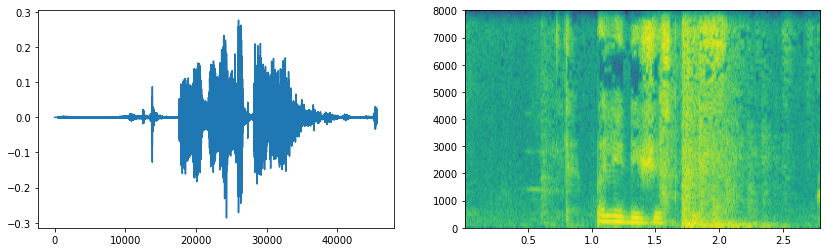

In [7]:
# load one recording
waveform, rate = lb.load('drive/MyDrive/Colab Notebooks/data/clips/1a7b4c57ea08555e6c968cbcc8875ecf70b3df42207e9556d71f1fd40b3de915d0bae21d9fe740aa56b32ad7b3dea958168bb3a84d583b3c6d46c5d2a7c5bcbe.mp3', sr = 16000)

fig, ax = plt.subplots(ncols=2, figsize=(14, 4))
ax[0].plot(waveform)
ax[1].specgram(waveform[1000:], Fs=16000, mode='psd', scale='dB')
plt.show()

#### Data Loader

In [8]:
# check out dataframe
df = pd.read_csv('drive/MyDrive/Colab Notebooks/data/ASR_train.csv')
print(df.keys())
print(df.head(5))

Index(['ID', 'up_votes', 'down_votes', 'age', 'gender', 'transcription'], dtype='object')
                                                  ID  ...                  transcription
0  002e50c29ac2890c7cb3b3d63dcbe512bc6850de206ca8...  ...                        Malicka
1  0031672b4484f963c8a07babe6f713dd559539d44140e8...  ...  Ecole Elementaire Pikine Nord
2  00362ccc6b48d3ea225e12ddf8a06a9d582cccc03b0353...  ...         Cimetière de Cambérène
3  0042cdb4d4a015cddacc26d88faffdd714b7a27213d2b3...  ...                Tournalou Boune
4  00439f02fa8f0dade934bdb317199b71662e9396f6bb81...  ...             Pharmacie Golf Sud

[5 rows x 6 columns]


In [9]:
# suppress annoying warnings while reading audio files
import warnings
warnings.filterwarnings('ignore')

In [10]:
## read into memory (small) -> storing takes around 2hrs
## IMPORTANT: it's not persisted across sessions (why not?)
nsamples = len(df)

# check if already existent
if os.path.isfile('drive/MyDrive/Colab Notebooks/data/ASR_train_audio'+str(nsamples)+'.ft'):
    print ("File exist")
    df = pd.read_feather('drive/MyDrive/Colab Notebooks/data/ASR_train_audio'+str(nsamples)+'.ft')
else:
    print("File does not exist")

    # initialize with list
    audio_signals = len(df['ID'])*[[0]]
    df['audio_signal'] = audio_signals

    # functional but not elegant (nor fast probably)
    for k in range(nsamples):
      id = df.iloc[k]['ID']
      path_data = os.path.join('drive/MyDrive/Colab Notebooks/data/clips/', id+'.mp3')
      waveform, rate = lb.load(path_data, sr=16*1e3)
      df.at[k, 'audio_signal'] = waveform

      if k % 100 == 0:
        print('file '+ str(k))

    # store as faster feather format
    df[:nsamples].to_feather('drive/MyDrive/Colab Notebooks/data/ASR_train_audio'+str(nsamples)+'.ft')

    #
    df = df[:nsamples]

File exist


### Model

#### XLSR Model Transformers

In [ ]:
## useful links
# https://github.com/pytorch/fairseq/tree/master/examples/wav2vec
# https://github.com/pytorch/fairseq/issues/3199
# https://bleepcoder.com/fairseq/708379224/wav2vec-2-0-inference-pipeline
# https://huggingface.co/transformers/training.html
# https://huggingface.co/blog/fine-tune-xlsr-wav2vec2 fine-tuning XLSR
# https://distill.pub/2017/ctc/ sequence modeling with CTC

#### Data

In [11]:
## train valid split
from sklearn.model_selection import train_test_split

# df_train -> used in optimization
# df_valid -> used to evaluate model during optimization
# df_valid2 -> independent set for testing
df_train, df_valid2 = train_test_split(df, test_size=0.2, random_state=1234)
df_train, df_valid = train_test_split(df_train, test_size=0.2, random_state=1234)

In [12]:
## dataset library (1-2GB/s data processing)
!pip install nlp
from nlp import Dataset

data_train = Dataset.from_pandas(df_train[['ID', 'transcription', 'audio_signal']])
data_valid = Dataset.from_pandas(df_valid[['ID', 'transcription', 'audio_signal']])

     |████████████████████████████████| 1.7MB 7.3MB/s 


In [13]:
## Lower casing (no punctuation included)
import re
def remove_special_characters(batch):
    batch['text'] = batch["transcription"].lower() + ' ' # lower casing + word separator at the end
    return batch

data_train = data_train.map(remove_special_characters, remove_columns=['transcription'])
data_valid = data_valid.map(remove_special_characters, remove_columns=['transcription'])

In [14]:
## build vocabulary
# Q: exclude {, | -} ?
'''
def extract_all_chars(batch):
  all_text = " ".join(batch['text'])
  vocab = list(set(all_text))
  return {"vocab": [vocab], "all_text": [all_text]}

vocab_train = data_train.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=data_train.column_names)
vocab_valid = data_valid.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=data_train.column_names)
'''

'\ndef extract_all_chars(batch):\n  all_text = " ".join(batch[\'text\'])\n  vocab = list(set(all_text))\n  return {"vocab": [vocab], "all_text": [all_text]}\n\nvocab_train = data_train.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=data_train.column_names)\nvocab_valid = data_valid.map(extract_all_chars, batched=True, batch_size=-1, keep_in_memory=True, remove_columns=data_train.column_names)\n'

In [15]:
'''
## creating vocab dictionary
import json
import os

#
vocab_list = list(set(vocab_train["vocab"][0]))

vocab_dict = {v: k for k, v in enumerate(vocab_list)}
print(vocab_dict)

# add unknown token, blank token
vocab_dict["[UNK]"] = len(vocab_dict)
vocab_dict["[PAD]"] = len(vocab_dict)

print(len(vocab_dict)) # dim required for linear layer

vocab_path = os.path.join(path, "data/vocab.json")
with open(vocab_path, 'w') as vocab_file:
    json.dump(vocab_dict, vocab_file)
'''

'\n## creating vocab dictionary\nimport json\nimport os\n\n#\nvocab_list = list(set(vocab_train["vocab"][0]))\n\nvocab_dict = {v: k for k, v in enumerate(vocab_list)}\nprint(vocab_dict)\n\n# add unknown token, blank token\nvocab_dict["[UNK]"] = len(vocab_dict)\nvocab_dict["[PAD]"] = len(vocab_dict)\n\nprint(len(vocab_dict)) # dim required for linear layer\n\nvocab_path = os.path.join(path, "data/vocab.json")\nwith open(vocab_path, \'w\') as vocab_file:\n    json.dump(vocab_dict, vocab_file)\n'

#### Pre-Processing

In [16]:
## tokenizer (for output text)
# tokenizer = Wav2Vec2CTCTokenizer(vocab_path, unk_token="[UNK]", pad_token="[PAD]", word_delimiter_token=" ")
tokenizer = Wav2Vec2CTCTokenizer.from_pretrained("facebook/wav2vec2-large-xlsr-53-french") # IMPORTANT: before used Wav2VecTokenizer (not CTC)

#tokenizer.get_vocab()

In [17]:
## feature extractor (best guess: for input to cut into windows, normalize etc.)
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=True)

## processor (combine tokenizer and feature extractor)
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

#### Preprocess Data

In [18]:
print(data_train[0]['ID'])
print(data_train[0]['text'])
print(data_train[0]['audio_signal'])

68332e61131492aa964bb376fc0e1d110e1bfd430f91dc0d0a9e79d4bf9ca5dfb0455f228c98b2ded11dee4ea1164f647dcbba73757c10a1c1e1bd00e3eb3ec3
nan laay def ba dem tally bou bess 
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.1133459605627838e-12, -1.0502000744733175e-12, 1.1029724225966597e-12, -5.180263770027116e-13, -1.2550960704765801e-12, 4.817344873703222e-12, -9.901867520367702e-12, 2.0706679426663044e-11, -3.3299227958361044e-11, 5.2526122340523784e-11, -7.694649778455798e-11, 1.0572724640223186e-10, -1.4036237450110178e-10, 1.77

In [19]:
## listen to a sample
import IPython.display as ipd

rand_int = random.randint(0, len(data_train))
print("Target text:", data_train[rand_int]["text"])

ipd.Audio(data=np.asarray(data_train[rand_int]["audio_signal"]), autoplay=True, rate=16000)

Target text: gendarmerie niague 


In [20]:
## extract input_values (normalization)
def prepare_dataset(batch):
    batch["input_values"] = processor(batch["audio_signal"], sampling_rate=16*1e3).input_values

    with processor.as_target_processor():
        batch["labels"] = processor(batch["text"]).input_ids
    return batch

# parameter num_proc does not exist in the currently used version of datasets
data_train = data_train.map(prepare_dataset, remove_columns=data_train.column_names, batch_size=8, batched=True)
data_valid = data_valid.map(prepare_dataset, remove_columns=data_valid.column_names, batch_size=8, batched=True)

#### Training

In [21]:
## data collator (dynamic padding)
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union

@dataclass
class DataCollatorCTCWithPadding:
    """
    Data collator that will dynamically pad the inputs received.
    Args:
        processor (:class:`~transformers.Wav2Vec2Processor`)
            The processor used for proccessing the data.
        padding (:obj:`bool`, :obj:`str` or :class:`~transformers.tokenization_utils_base.PaddingStrategy`, `optional`, defaults to :obj:`True`):
            Select a strategy to pad the returned sequences (according to the model's padding side and padding index)
            among:
            * :obj:`True` or :obj:`'longest'`: Pad to the longest sequence in the batch (or no padding if only a single
              sequence if provided).
            * :obj:`'max_length'`: Pad to a maximum length specified with the argument :obj:`max_length` or to the
              maximum acceptable input length for the model if that argument is not provided.
            * :obj:`False` or :obj:`'do_not_pad'` (default): No padding (i.e., can output a batch with sequences of
              different lengths).
        max_length (:obj:`int`, `optional`):
            Maximum length of the ``input_values`` of the returned list and optionally padding length (see above).
        max_length_labels (:obj:`int`, `optional`):
            Maximum length of the ``labels`` returned list and optionally padding length (see above).
        pad_to_multiple_of (:obj:`int`, `optional`):
            If set will pad the sequence to a multiple of the provided value.
            This is especially useful to enable the use of Tensor Cores on NVIDIA hardware with compute capability >=
            7.5 (Volta).
    """

    processor: Wav2Vec2Processor
    padding: Union[bool, str] = True
    max_length: Optional[int] = None
    max_length_labels: Optional[int] = None
    pad_to_multiple_of: Optional[int] = None
    pad_to_multiple_of_labels: Optional[int] = None

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lenghts and need
        # different padding methods
        input_features = [{"input_values": feature["input_values"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]

        batch = self.processor.pad(
            input_features,
            padding=self.padding,
            max_length=self.max_length,
            pad_to_multiple_of=self.pad_to_multiple_of,
            return_tensors="pt",
        )
        with self.processor.as_target_processor():
            labels_batch = self.processor.pad(
                label_features,
                padding=self.padding,
                max_length=self.max_length_labels,
                pad_to_multiple_of=self.pad_to_multiple_of_labels,
                return_tensors="pt",
            )

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        batch["labels"] = labels

        # input_values, attention_mask, labels
        return batch

data_collator = DataCollatorCTCWithPadding(processor=processor, padding=True)

In [22]:
## metric
!pip install jiwer
from datasets import load_metric

wer_metric = load_metric("wer")

def compute_metrics(pred):
    # argmax of softmax
    pred_logits = pred.predictions
    pred_ids = np.argmax(pred_logits, axis=-1)

    # -100 id -> pad token
    pred.label_ids[pred.label_ids == -100] = processor.tokenizer.pad_token_id

    # prediction id -> character
    pred_str = processor.batch_decode(pred_ids)
    # we do not want to group tokens when computing the metrics?
    label_str = processor.batch_decode(pred.label_ids, group_tokens=False)

    wer = wer_metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

     |████████████████████████████████| 51kB 4.4MB/s 
  Created wheel for python-Levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-linux_x86_64.whl size=149806 sha256=6a7958fb874cd13583a25e29aa55c1ac8e76da4746e41fe7ef4d206824f2c7f9
  Stored in directory: /root/.cache/pip/wheels/b3/26/73/4b48503bac73f01cf18e52cd250947049a7f339e940c5df8fc
Successfully built python-Levenshtein


In [24]:
## model
## Note: play around with hyperparameters (take training to laptop and perform grid search?)

model = Wav2Vec2ForCTC.from_pretrained(
    "facebook/wav2vec2-large-xlsr-53-french",
    attention_dropout=0.1,
    hidden_dropout=0.1,
    feat_proj_dropout=0.0,
    mask_time_prob=0.05,
    layerdrop=0.1,
    gradient_checkpointing=True, # save GPU memory
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id, # define pad token
    #vocab_size=len(processor.tokenizer) -> mis-match of last layer due to vocab size
)

# TODO: remove output layer and replace with vocabulary sized

In [25]:
model.to('cuda');

In [26]:
## Freeze CNN layers (no fine tuning as stated in paper)
model.freeze_feature_extractor()

In [27]:
# TESTING: freeze all layers
'''
for name, param in model.named_parameters():
  # param.requires_grad = False
  if 'lm_head' not in name:
    param.requires_grad = False

  if param.requires_grad:
    print(name)
'''

"\nfor name, param in model.named_parameters():\n  # param.requires_grad = False\n  if 'lm_head' not in name:\n    param.requires_grad = False\n\n  if param.requires_grad:\n    print(name)\n"

In [28]:
# adapt last layer to vocab size
# (lm_head): Linear(in_features=1024, out_features=37, bias=True)
# model.lm_head = torch.nn.Linear(1024, out_features=len(processor.tokenizer), bias=True)

In [29]:
## hyperparameters
from transformers import TrainingArguments

path_model = os.path.join(path, '/model/wav2vec2-large-xlsr-french-13Apr')

training_args = TrainingArguments(
  output_dir='./drive/MyDrive/Colab Notebooks/model/wav2vec2-large-xlsr-french-13Apr/',
  group_by_length=True,
  per_device_train_batch_size=16,
  gradient_accumulation_steps=2,
  evaluation_strategy="steps",
  num_train_epochs=1,
  fp16=True,
  save_steps=100,
  eval_steps=100,
  logging_steps=70,
  learning_rate=3e-4,
  warmup_steps=0,
  save_total_limit=1,
)

In [30]:
## Trainer
from transformers import Trainer

trainer = Trainer(
    model=model,
    data_collator=data_collator,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=data_train,
    eval_dataset=data_valid,
    tokenizer=processor.feature_extractor,
)

In [ ]:
## prevent disconnecting
# right mouse click -> inspect -> Console tab and insert code
'''
function ConnectButton(){
    console.log("Connect pushed");
    document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click()
}
setInterval(ConnectButton,60000);
'''

In [ ]:
## start training
model.train()
trainer.train()

Step,Training Loss,Validation Loss,Wer
100,nan,nan,1.000000


TrainOutput(global_step=134, training_loss=nan, metrics={'train_runtime': 438.157, 'train_samples_per_second': 0.306, 'total_flos': 4.045152610904371e+17, 'epoch': 1.0, 'train_mem_cpu_alloc_delta': -528240640, 'train_mem_gpu_alloc_delta': 34772480, 'train_mem_cpu_peaked_delta': 701804544, 'train_mem_gpu_peaked_delta': 3086871040})

### Evaluation

In [ ]:
from datasets import load_metric

#from transformers import Wav2Vec2ForCTC, Wav2Vec2Processor
if not 'model' in globals():
  print('Load model')
  model = Wav2Vec2ForCTC.from_pretrained('./drive/MyDrive/Colab Notebooks/model/wav2vec2-large-xlsr-french-test/checkpoint-750/').to("cuda")

model.eval();

# new processor if not yet existent
if not 'processor' in globals():
  print('Load processor')
  tokenizer = Wav2Vec2CTCTokenizer.from_pretrained("facebook/wav2vec2-large-xlsr-53-french")
  feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=True)
  processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)
  # processor = Wav2Vec2Processor.from_pretrained('./drive/MyDrive/Colab Notebooks/model/wav2vec2-large-xlsr-french-test/checkpoint-150/') # for some reason the file is not found

#
def prepare_dataset(batch):
    return processor(batch, return_tensors="pt", sampling_rate=16*1e3)

wer_ = []

#
input_dict = df_valid2['audio_signal'].apply(prepare_dataset)
label_str = ''
pred_str = ''

for idx in range(len(df_valid2)):
  #print('-----------------')
  logits = model(input_dict.values[idx].input_values.to("cuda")).logits
  pred_ids = torch.argmax(logits, dim=-1)[0]

  '''
  pred = []
  for word in processor.decode(pred_ids).split(' '):
    sim = difflib.get_close_matches(word, xv, n=1)
    if sim == []:
      sim = word
    else:
      sim = sim[0]
        
    pred.append(sim)
  
  #print("Prediction:")
  pred_str+= ' '.join(pred)+ ' '
  '''
  pred_str+= processor.decode(pred_ids)+ ' '

  #print("\nReference:")
  label_str+= df_valid2["transcription"].values[idx].lower()+ ' '

  # need same length for wer_metric
  #label_str = label_str.ljust(len(pred_str))
  #pred_str = pred_str.ljust(len(label_str))
wer_.append(wer_metric.compute(predictions=[pred_str], references=[label_str]))

np.mean(wer_)

1.0

In [ ]:
asdf

In [ ]:
print(pred_str[:1000])
print(label_str[:1000])

In [ ]:
wer_metric.compute(predictions=[pred_str], references=[label_str])

In [ ]:
audio_signal = df[df['ID']=='de242ae13e8bc5c14e01295dd52eb0d3cc5b7e224507a6decd664eecdad6de5d9fb81c592fae6aadf4830955c36e9620cf07ea38b07675e513b23c0842233596']['audio_signal'].values
input_dict = processor(audio_signal[0], return_tensors="pt", sampling_rate=16*1e3)

logits = model(input_dict.input_values.to("cuda")).logits
pred_ids = torch.argmax(logits, dim=-1)[0]

#print("Prediction:")
pred_str = processor.decode(pred_ids)
print(pred_str)

### Prediction

In [ ]:
## prediction
# load data (dataframe) -> empty entries
df_test = pd.read_feather('drive/MyDrive/Colab Notebooks/data/ASR_test_audio1564.ft')
df_test = df_test[['ID', 'audio_signal']]

df_test.head()

'''
# pre-process (processor)
from transformers import Wav2Vec2CTCTokenizer, Wav2Vec2FeatureExtractor, Wav2Vec2Processor, Wav2Vec2ForCTC

tokenizer = Wav2Vec2CTCTokenizer.from_pretrained("facebook/wav2vec2-large-xlsr-53-french") #
feature_extractor = Wav2Vec2FeatureExtractor(feature_size=1, sampling_rate=16000, padding_value=0.0, do_normalize=True, return_attention_mask=True)
processor = Wav2Vec2Processor(feature_extractor=feature_extractor, tokenizer=tokenizer)

# pass through model
modelTest = Wav2Vec2ForCTC.from_pretrained('./drive/MyDrive/Colab Notebooks/model/wav2vec2-large-xlsr-french-test/checkpoint-280/').to("cuda")
'''

def prepare_dataset(batch):
    return processor(batch, return_tensors="pt", sampling_rate=16*1e3)

In [ ]:
# run through processor
import difflib
input_dict = df_test['audio_signal'].apply(prepare_dataset)
preds = []

# run through model and decoder
for i in range(len(df_test)):
  logits = model(input_dict[i].input_values.to('cuda')).logits
  pred_ids = torch.argmax(logits, dim=-1)
  preds.append(processor.decode(pred_ids[0]))

  '''
  pred = []
  for word in processor.decode(pred_ids[0]).split(' '):
    sim = difflib.get_close_matches(word, xv, n=1)
    if sim == []:
      sim = word
    else:
      sim = sim[0]
        
    pred.append(sim)
  
  preds.append(''.join(pred))
  '''


# save as csv
dfpred = pd.DataFrame(list(zip(list(df_test['ID'].values), preds)), columns=['ID', 'transcription'])
dfpred.to_csv('./drive/MyDrive/Colab Notebooks/predictions_11Apr.csv', index=False)

In [ ]:
## listen to a sample
import IPython.display as ipd

rand_int = 1555#random.randint(0, len(df_test))
print("Target text:", dfpred["transcription"].values[rand_int])

ipd.Audio(data=np.asarray(df_test["audio_signal"].values[rand_int]), autoplay=True, rate=16000)

In [ ]:
df_test[df_test['ID']=='fe5ab7babd3bd7e07c8a8cb41285e28815de7dbe9e96d8d2ece6159957d207240ad7dfbdae1da12919f2e652672e3f53d5549e7348cad28365e3b7d3416e778a']

In [ ]:
from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator

#
words = df['transcription']
allwords = []

for wordlist in words:
  allwords += list(wordlist.lower().split())

# histogram
mostcommon_small = FreqDist(allwords).most_common(10000)
xv, yv = zip(*mostcommon_small)

In [ ]:
from nltk.probability import FreqDist
from wordcloud import WordCloud, ImageColorGenerator

#
words = dfpred['transcription']
allwords = []

for wordlist in words:
  allwords += list(wordlist.split())

# histogram
mostcommon_small = FreqDist(allwords).most_common(10000)
xp, yp = zip(*mostcommon_small)

fig, ax = plt.subplots(nrows=2, figsize=(22,10))
ax[0].bar(xv,yv)
ax[1].bar(xp,yp)
plt.xlabel('Words')
plt.ylabel('Frequency of Words')
plt.xticks(rotation=60)
plt.show()

In [ ]:
print(len(xv))
print(len(xp))

In [ ]:
count_all = 0
count_notshared = 0
count = 0
for k, word in enumerate(xp):
  count_all += yp[k]
  if word not in xv:
    count_notshared += yp[k]
    #print(word+ ' '+ str(yp[k]))
    count += 1

print(count_all)
print(count_notshared)
print(count)